
<br>
<h1 style="text-align:center; font-size:46px; font-weight:800; margin-bottom:0;">
Cybersecurity - IoT Intrusion Dataset
</h1>
<p style="text-align:center; font-size:22px; color:gray; margin-top:5px;">
Conv1D Neural Network for Time Series Analysis
</p>
<br>
<p style="text-align:center;">
  <img src="img/ai.jpg" style="width:85%; max-width:900px; border-radius:10px; box-shadow:0px 0px 12px rgba(0,0,0,0.25);">
</p>
<br>
<p style="text-align:center; font-size:16px; color:gray;">
Environment & Tools: Python • PyTorch • NumPy • Pandas • Scikit-Learn • Matplotlib
</p>
<br>


The dataset used in this analysis is publicly available from an open-source repository on Kaggle.  
You can access it here: [insert URL].

We will be using a **1D Convolutional Neural Network (Conv1D CNN)** to perform **time-series analysis** on the dataset.
Conv1D is particularly suited for sequential data, as it can capture temporal patterns across the input sequence of features.


<hr>
<h2 style="text-align:center; font-weight:700;">📚 Libraries Used in This Project</h2>
<p style="text-align:center; color:gray; font-size:15px;">Core tools used for data processing, modeling, and visualization.</p>
<br>
<table style="margin-left:auto; margin-right:auto; text-align:center;">
  <tr>
    <td><img src="img/numpy.jpg" width="60"><br><strong>NumPy</strong><br><span style="color:gray; font-size:13px;">Numerical<br>Computing</span></td>
    <td><img src="img/pandas.png" width="60"><br><strong>Pandas</strong><br><span style="color:gray; font-size:13px;">Data<br>Manipulation</span></td>
    <td><img src="img/pytorch.jpg" width="100"><br><strong>PyTorch</strong><br><span style="color:gray; font-size:13px;">Deep<br>Learning</span></td>
  </tr>
  <tr>
    <td><img src="img/scikitlearn.png" width="60"><br><strong>Scikit-Learn</strong><br><span style="color:gray; font-size:13px;">ML Tools<br>& Metrics</span></td>
    <td><img src="img/matplotlib.jpg" width="90"><br><strong>Matplotlib</strong><br><span style="color:gray; font-size:13px;">Visualization</span></td>
  </tr>
</table>
<br>
<hr>


Importing Libraries and Modules

In [3]:
"""
Created on Thu Oct 23 18:45:00 2025

@author: ybenjaminpcondori
"""

# System & OS utilities
import os

# Data manipulation
import numpy as np
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Scikit-Learn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, f1_score, recall_score,
                             confusion_matrix, roc_auc_score, accuracy_score)
from sklearn.metrics import precision_score


# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl

# Importing Seaborn for enhanced visualizations
import seaborn as sns


Declaring Classes and Functions

In [2]:
class Convolutional_Neural_Network(nn.Module):
    def __init__(self, num_classes, num_features):
        super().__init__()

        # Convolutional feature extractor
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        
        # Increased from 64 re→ 128 (better feature extraction)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        
        # Slightly reduced from 256 re→ 192 (more stable for tabular data)
        self.conv3 = nn.Conv1d(128, 192, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.conv_dropout = nn.Dropout1d(0.2)

        # Determine flatten size dynamically 
        with torch.no_grad():
            dummy = torch.zeros(1, 1, num_features)
            d = self._extract_features(dummy)
            self.flatten_dim = d.shape[1]

        # Classification head 
        self.fc1 = nn.Linear(self.flatten_dim, 64)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(64, num_classes)

    def _extract_features(self, x):
        x = self.relu(self.conv1(x))
        x = self.conv_dropout(x)
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.conv_dropout(x)
        x = self.pool(x)

        x = self.relu(self.conv3(x))
        x = self.global_pool(x)

        return x.squeeze(-1)  # (batch, channels)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, features)
        x = self._extract_features(x)
        x = self.dropout(self.relu(self.fc1(x)))
        return self.out(x)

# Binary counting helper class
class DataPreprocessing:

    @staticmethod
    def count_binary(series):
        counts = series.value_counts()
        return pd.Series({'0': counts.get(0, 0), '1': counts.get(1, 0)})

## Data Preprocessing

Loading the Dataset

In [3]:
# Reading the CSV Dataset using Pandas
df = pd.read_csv("IoT_Intrusion.csv")

# Sripping whitespace and converting to lowercase
df.columns = df.columns.str.strip().str.lower()

# Displaying the first few rows of the dataframe
df.head()

,flow_duration,header_length,protocol type,duration,rate,srate,drate,fin_flag_number,syn_flag_number,rst_flag_number,...,std,tot size,iat,number,magnitue,radius,covariance,variance,weight,label
0,0.000000,54.00,6.00,64.00,0.329807,0.329807,0.0,1,0,1,...,0.000000,54.00,83343831.92,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-RSTFINFlood
1,0.000000,57.04,6.33,64.00,4.290556,4.290556,0.0,0,0,0,...,2.822973,57.04,82926067.47,9.5,10.464666,4.010353,160.987842,0.05,141.55,DoS-TCP_Flood
2,0.000000,0.00,1.00,64.00,33.396799,33.396799,0.0,0,0,0,...,0.000000,42.00,83127993.93,9.5,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood
3,0.328175,76175.00,17.00,64.00,4642.133010,4642.133010,0.0,0,0,0,...,0.000000,50.00,83015696.38,9.5,10.000000,0.000000,0.000000,0.00,141.55,DoS-UDP_Flood
4,0.117320,101.73,6.11,65.91,6.202211,6.202211,0.0,0,1,0,...,23.113111,57.88,82972999.18,9.5,11.346876,32.716243,3016.808286,0.19,141.55,DoS-SYN_Flood


Declaration of Columns: Network Protocols

In [4]:
# Analyzing binary columns
protocol_columns = ['http','https','dns','telnet','smtp','ssh','irc','tcp','udp','dhcp','arp','icmp','ipv','llc']
for col in protocol_columns:
    _ = df[col].value_counts()

Feature Importance: Number of instances of 0/1 in each feature

In [5]:
# Counting binary values in specified columns
counts_df = df[protocol_columns].apply(DataPreprocessing.count_binary)
print(counts_df)

# Printing label statistics
print("Binary label statistics:")
print("Unique label count:", df['label'].nunique())
print("Unique labels:", df['label'].unique())
print("Label counts:\n", df['label'].value_counts())

     http   https      dns   telnet     smtp      ssh      irc     tcp  \
0  997735  990633  1048433  1048575  1048575  1048512  1048575  446278   
1   50840   57942      142        0        0       63        0  602297   

      udp     dhcp      arp    icmp      ipv      llc  
0  826349  1048573  1048505  877307      119      119  
1  222226        2       70  171268  1048456  1048456  
Binary label statistics:
Unique label count: 34
Unique labels: ['DDoS-RSTFINFlood' 'DoS-TCP_Flood' 'DDoS-ICMP_Flood' 'DoS-UDP_Flood'
 'DoS-SYN_Flood' 'Mirai-greeth_flood' 'DDoS-SynonymousIP_Flood'
 'Mirai-udpplain' 'DDoS-SYN_Flood' 'DDoS-PSHACK_Flood' 'DDoS-TCP_Flood'
 'DDoS-UDP_Flood' 'BenignTraffic' 'MITM-ArpSpoofing'
 'DDoS-ACK_Fragmentation' 'Mirai-greip_flood' 'DoS-HTTP_Flood'
 'DDoS-ICMP_Fragmentation' 'Recon-PortScan' 'DNS_Spoofing'
 'DDoS-UDP_Fragmentation' 'Recon-OSScan' 'XSS' 'DDoS-HTTP_Flood'
 'Recon-HostDiscovery' 'CommandInjection' 'VulnerabilityScan'
 'DDoS-SlowLoris' 'Backdoor_Malware' '

Caclulating Uniques Values, important for identifying rows that don't contribute to the feature prediction/classification

In [6]:
# -----------------------------
# Calculating unique values
# -----------------------------

print("\nUnique Value Counts")
print("=" * 50)

protocol_columns_nunique = df[protocol_columns].nunique()
print(protocol_columns_nunique)


Unique Value Counts
http      2
https     2
dns       2
telnet    1
smtp      1
ssh       2
irc       1
tcp       2
udp       2
dhcp      2
arp       2
icmp      2
ipv       2
llc       2
dtype: int64


Declaration of Columns: Signal Processing Columns

In [7]:
# Columns to analyze
other_columns = [
    "flow_duration",
    "header_length",
    "duration",
    "rate",
    "srate",
    "drate",
    "fin_flag_number",
    "syn_flag_number",
]

# ommited protocol type

Null Value Analysis of Other Columns

In [8]:
# Null value analysis
print("Null Value Analysis for Other Columns")
print("=" * 50)

for col in other_columns:
    null_count = df[col].isnull().sum()
    null_ratio = df[col].isnull().mean()

    print(f"{col:20s} | nulls: {null_count:8d} | ratio: {null_ratio:.4f}")

Null Value Analysis for Other Columns
flow_duration        | nulls:        0 | ratio: 0.0000
header_length        | nulls:        0 | ratio: 0.0000
duration             | nulls:        0 | ratio: 0.0000
rate                 | nulls:        0 | ratio: 0.0000
srate                | nulls:        0 | ratio: 0.0000
drate                | nulls:        0 | ratio: 0.0000
fin_flag_number      | nulls:        0 | ratio: 0.0000
syn_flag_number      | nulls:        0 | ratio: 0.0000


In [9]:
# -----------------------------
# Calculating unique values
# -----------------------------

print("\nUnique Value Counts")
print("=" * 50)

other_columns_nunique = df[other_columns].nunique()
print(other_columns_nunique)


Unique Value Counts
flow_duration      476819
header_length      187878
duration             6910
rate               872923
srate              872923
drate                  61
fin_flag_number         2
syn_flag_number         2
dtype: int64


Declaration of Columns: Numeric Columns

In [10]:
# Columns with different names
different_columns = [
    "tot size",
    "magnitue",
    "iat",
]

In [11]:

# Renaming columns for consistency
df = df.rename(columns = {
    "tot size": "total_size",
    "magnitue": "magnitude",
    "iat": "inter_arrival_time",
})

different_columns = ["total_size", "magnitude", "inter_arrival_time"]



In [12]:
# Null value analysis
print("Null Value Analysis for Different Columns")
print("=" * 50)

for col in different_columns:
    null_count = df[col].isnull().sum()
    null_ratio = df[col].isnull().mean()

    print(f"{col:20s} | nulls: {null_count:8d} | ratio: {null_ratio:.4f}")

Null Value Analysis for Different Columns
total_size           | nulls:        0 | ratio: 0.0000
magnitude            | nulls:        0 | ratio: 0.0000
inter_arrival_time   | nulls:        0 | ratio: 0.0000


Caclulation Uniques Values, important for identifying rows that don't contribute to the feature prediction/classification

In [13]:
# -----------------------------
# Calculating unique values
# -----------------------------
print("\nUnique Value Counts")
print("=" * 50)

different_columns_nunique = df[different_columns].nunique()
print(different_columns_nunique)


Unique Value Counts
total_size             35365
magnitude             166571
inter_arrival_time    740225
dtype: int64


Data Cleaning

In [14]:
# Detecting rows with identical features, but different target feature (Label)

# Identify feature columns (exclude target)
feature_cols = df.columns.difference(['label']).tolist()

print("Detecting feature-identical rows with multiple target labels")
print("=" * 50)

# Detect feature-identical rows with multiple target labels
label_variation = (
    df
    .groupby(feature_cols)['label']
    .nunique()
    .reset_index(name='n_labels')
)

# Keep only conflicting feature patterns
conflicting_patterns = label_variation[label_variation['n_labels'] > 1]

# Retrieve all rows involved in label conflicts
df_conflicts = df.merge(
    conflicting_patterns[feature_cols],
    on=feature_cols,
    how='inner',
)
    # Retrieve all rows involved in label conflicts
print(df_conflicts.sort_values(feature_cols))


Detecting feature-identical rows with multiple target labels
Empty DataFrame
Columns: [flow_duration, header_length, protocol type, duration, rate, srate, drate, fin_flag_number, syn_flag_number, rst_flag_number, psh_flag_number, ack_flag_number, ece_flag_number, cwr_flag_number, ack_count, syn_count, fin_count, urg_count, rst_count, http, https, dns, telnet, smtp, ssh, irc, tcp, udp, dhcp, arp, icmp, ipv, llc, tot sum, min, max, avg, std, total_size, inter_arrival_time, number, magnitude, radius, covariance, variance, weight, label]
Index: []

[0 rows x 47 columns]


In [15]:

# Detect constant columns across the FULL dataset (excluding label)
feature_cols = df.columns.difference(['label']).tolist()

global_nunique = df[feature_cols].nunique()

constant_cols = global_nunique[global_nunique == 1].index.tolist()

print("Dropping constant columns:", constant_cols)

df.drop(columns=constant_cols, inplace=True)

Dropping constant columns: ['cwr_flag_number', 'ece_flag_number', 'irc', 'smtp', 'telnet']


Missingness Heatmap of Dataset

In [16]:
df.isna().sum().sort_values(ascending=False)


flow_duration         0
avg                   0
dhcp                  0
arp                   0
icmp                  0
ipv                   0
llc                   0
tot sum               0
min                   0
max                   0
std                   0
header_length         0
total_size            0
inter_arrival_time    0
number                0
magnitude             0
radius                0
covariance            0
variance              0
weight                0
udp                   0
tcp                   0
ssh                   0
dns                   0
protocol type         0
duration              0
rate                  0
srate                 0
drate                 0
fin_flag_number       0
syn_flag_number       0
rst_flag_number       0
psh_flag_number       0
ack_flag_number       0
ack_count             0
syn_count             0
fin_count             0
urg_count             0
rst_count             0
http                  0
https                 0
label           

Class Distribution

/tmp/ipykernel_79303/2351757671.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


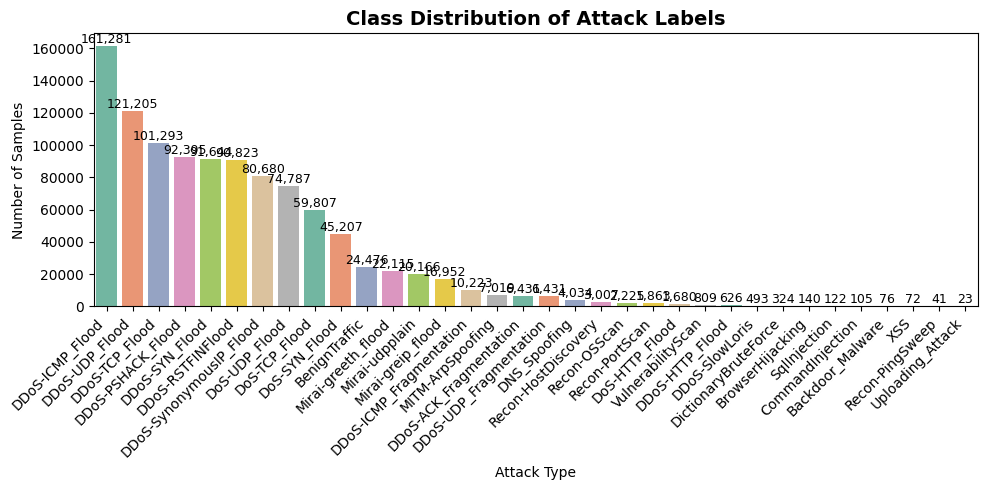

In [17]:
plt.figure(figsize=(10, 5))

label_counts = df["label"].value_counts()

ax = sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    palette="Set2"
)

# Add numbers on top of bars
for i, v in enumerate(label_counts.values):
    ax.text(i, v, f"{v:,}", ha="center", va="bottom", fontsize=9)

plt.title("Class Distribution of Attack Labels", fontsize=14, fontweight="bold")
plt.xlabel("Attack Type")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [18]:
label_counts = df["label"].value_counts()

print(label_counts)

label
DDoS-ICMP_Flood            161281
DDoS-UDP_Flood             121205
DDoS-TCP_Flood             101293
DDoS-PSHACK_Flood           92395
DDoS-SYN_Flood              91644
DDoS-RSTFINFlood            90823
DDoS-SynonymousIP_Flood     80680
DoS-UDP_Flood               74787
DoS-TCP_Flood               59807
DoS-SYN_Flood               45207
BenignTraffic               24476
Mirai-greeth_flood          22115
Mirai-udpplain              20166
Mirai-greip_flood           16952
DDoS-ICMP_Fragmentation     10223
MITM-ArpSpoofing             7019
DDoS-ACK_Fragmentation       6431
DDoS-UDP_Fragmentation       6431
DNS_Spoofing                 4034
Recon-HostDiscovery          3007
Recon-OSScan                 2225
Recon-PortScan               1863
DoS-HTTP_Flood               1680
VulnerabilityScan             809
DDoS-HTTP_Flood               626
DDoS-SlowLoris                493
DictionaryBruteForce          324
BrowserHijacking              140
SqlInjection                  122
CommandI

Identify Features and Target Columns

In [19]:
encoder = LabelEncoder()
df['label_encoded'] = encoder.fit_transform(df['label'])

In [20]:

# Class to Attack Label Mapping 

id_to_attack = dict(enumerate(encoder.classes_))
attack_to_id = {label: idx for idx, label in id_to_attack.items()}

# Displaying the class ID to attack type mapping
print("\nClass ID → Attack Type mapping:\n")
for k, v in id_to_attack.items():
    print(f"Class {k}: {v}")
 
# Saving the mapping to a CSV file
mapping_df = pd.DataFrame({
    "Class ID": list(id_to_attack.keys()),
    "Attack Type": list(id_to_attack.values())
})

# Saving the mapping to a CSV file
mapping_df.to_csv("class_label_mapping.csv", index=False)
print("\n[✓] Saved class_label_mapping.csv")



Class ID → Attack Type mapping:

Class 0: Backdoor_Malware
Class 1: BenignTraffic
Class 2: BrowserHijacking
Class 3: CommandInjection
Class 4: DDoS-ACK_Fragmentation
Class 5: DDoS-HTTP_Flood
Class 6: DDoS-ICMP_Flood
Class 7: DDoS-ICMP_Fragmentation
Class 8: DDoS-PSHACK_Flood
Class 9: DDoS-RSTFINFlood
Class 10: DDoS-SYN_Flood
Class 11: DDoS-SlowLoris
Class 12: DDoS-SynonymousIP_Flood
Class 13: DDoS-TCP_Flood
Class 14: DDoS-UDP_Flood
Class 15: DDoS-UDP_Fragmentation
Class 16: DNS_Spoofing
Class 17: DictionaryBruteForce
Class 18: DoS-HTTP_Flood
Class 19: DoS-SYN_Flood
Class 20: DoS-TCP_Flood
Class 21: DoS-UDP_Flood
Class 22: MITM-ArpSpoofing
Class 23: Mirai-greeth_flood
Class 24: Mirai-greip_flood
Class 25: Mirai-udpplain
Class 26: Recon-HostDiscovery
Class 27: Recon-OSScan
Class 28: Recon-PingSweep
Class 29: Recon-PortScan
Class 30: SqlInjection
Class 31: Uploading_Attack
Class 32: VulnerabilityScan
Class 33: XSS

[✓] Saved class_label_mapping.csv


In [21]:
# Handling missing values
target = 'label_encoded'
features = [c for c in df.columns if c not in ['label', 'label_encoded']]

# Fill missing values in
numeric_features = df[features].select_dtypes(include=np.number).columns
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].mean())


In [22]:
# Creation of X and Y values
X = df[features].values
y = df[target].values

print(X.shape, y.shape)

(1048575, 41) (1048575,)


Train / Test Split

In [23]:

# Splitting the dataset into training and testing sets with stratification
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [24]:

print("Initial Training Mean (first 5):", X_train_np.mean(axis=0)[:5])
print("Initial Training Std (first 5):", X_train_np.std(axis=0)[:5])

# 4. Preprocessing
scaler = StandardScaler()
# Fit and transform the training data, overwriting X_train_np
X_train_np = scaler.fit_transform(X_train_np)
# Transform the test data using the SAME scaler
X_test_np  = scaler.transform(X_test_np)

# 5. Optional: Verify scaling results
# Mean should be ~0, Std should be ~1
print("Scaled Training Mean:", X_train_np.mean(axis=0)[:5])


Initial Training Mean (first 5): [5.70200401e+00 7.79822376e+04 9.06334672e+00 6.63504510e+01
 9.14286094e+03]
Initial Training Std (first 5): [2.95094984e+02 4.69336227e+05 8.93742669e+00 1.40615843e+01
 9.97545443e+04]
Scaled Training Mean: [-5.45787333e-16  3.00411829e-14 -8.02676707e-13  4.37911978e-12
 -3.23337768e-15]


In [25]:
# Converting to PyTorch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.long)
y_test = torch.tensor(y_test_np, dtype=torch.long)

# Displaying the shapes of the training and testing tensors
print(X_train.shape, X_test.shape)

torch.Size([838860, 41]) torch.Size([209715, 41])


In [26]:
# Creating DataLoader based on batch size
batch_size = 4096
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

In [27]:
# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Class Weights Computation

In [28]:

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_np),
    y=y_train_np
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class weights:", class_weights)


Class weights: tensor([4.0446e+02, 1.2600e+00, 2.2029e+02, 2.9372e+02, 4.7954e+00, 4.9246e+01,
        1.9122e-01, 3.0169e+00, 3.3379e-01, 3.3957e-01, 3.3653e-01, 6.2620e+01,
        3.8226e-01, 3.0447e-01, 2.5445e-01, 4.7954e+00, 7.6456e+00, 9.5260e+01,
        1.8357e+01, 6.8222e-01, 5.1566e-01, 4.1237e-01, 4.3940e+00, 1.3945e+00,
        1.8192e+00, 1.5293e+00, 1.0255e+01, 1.3861e+01, 7.4765e+02, 1.6559e+01,
        2.5176e+02, 1.3707e+03, 3.8133e+01, 4.2539e+02], device='cuda:0')


Model Definition

In [6]:
# Model instantiation
num_classes = len(df[target].unique())
num_features = X_train.shape[1]


# Convolutional Neural Network model
model = Convolutional_Neural_Network(num_classes, num_features).to(device)
print(model)

NameError: name 'df' is not defined

Training

In [30]:
# Loss Function Crossentropy Loss
loss_function = nn.CrossEntropyLoss(
    weight=(class_weights ** 0.5339094792991099).to(device)
)


# Optimizer hyperparameters

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0015595687975406929,
    weight_decay=0.000991366039667028
)


# Learning rate scheduler to reduce LR on plateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
)
 
# Training hyperparameters
num_epochs = 50

# Early Stopping 
best_val_loss = float("inf")
patience = 5          # stop after 5 bad epochs
patience_ctr = 0
min_delta = 1e-4
best_model_path = "Model"

loss_across_epochs = []
val_accuracy_across_epochs = []

In [31]:
# Training loop with validation and learning rate scheduling
for epoch in range(num_epochs):
    # -------- Train --------
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    # For looping through training batches
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Training using backpropagation
        optimizer.zero_grad()
        logits = model(batch_x)
        loss = loss_function(logits, batch_y)
        loss.backward()
        optimizer.step()

        # Accumulate loss (sum over samples)
        total_loss += loss.item() * batch_x.size(0)

        # Accumulate accuracy
        preds = torch.argmax(logits, dim=1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)

    # Calculating average training loss/accuracy
    train_loss = total_loss / len(train_loader.dataset)
    train_acc = correct / total if total > 0 else 0.0

    # -------- Validation (using test_loader as validation set) --------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for bx, by in test_loader:
            bx, by = bx.to(device), by.to(device)
            logits = model(bx)
            val_loss += loss_function(logits, by).item() * bx.size(0)

            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == by).sum().item()
            val_total += by.size(0)

    # Calculating average validation loss/accuracy
    val_loss /= len(test_loader.dataset)
    val_acc = val_correct / val_total if val_total > 0 else 0.0

    loss_across_epochs.append(train_loss)
    val_accuracy_across_epochs.append(val_acc)


    # Scheduler step
    scheduler.step(val_loss)

    # Printing Training progress
    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Acc: {val_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"LR: {optimizer.param_groups[0]['lr']:.2e}"
    )

Epoch 1/50 | Train Acc: 0.4974 | Train Loss: 1.7792 | Val Acc: 0.7547 | Val Loss: 0.8823 | LR: 1.56e-03
Epoch 2/50 | Train Acc: 0.7292 | Train Loss: 0.9015 | Val Acc: 0.7715 | Val Loss: 0.7500 | LR: 1.56e-03
Epoch 3/50 | Train Acc: 0.7599 | Train Loss: 0.7932 | Val Acc: 0.7830 | Val Loss: 0.6972 | LR: 1.56e-03
Epoch 4/50 | Train Acc: 0.7722 | Train Loss: 0.7463 | Val Acc: 0.7896 | Val Loss: 0.6754 | LR: 1.56e-03
Epoch 5/50 | Train Acc: 0.7765 | Train Loss: 0.7250 | Val Acc: 0.7913 | Val Loss: 0.6677 | LR: 1.56e-03
Epoch 6/50 | Train Acc: 0.7793 | Train Loss: 0.7092 | Val Acc: 0.7931 | Val Loss: 0.6594 | LR: 1.56e-03
Epoch 7/50 | Train Acc: 0.7832 | Train Loss: 0.6947 | Val Acc: 0.7984 | Val Loss: 0.6490 | LR: 1.56e-03
Epoch 8/50 | Train Acc: 0.7861 | Train Loss: 0.6851 | Val Acc: 0.8015 | Val Loss: 0.6292 | LR: 1.56e-03
Epoch 9/50 | Train Acc: 0.7904 | Train Loss: 0.6698 | Val Acc: 0.8074 | Val Loss: 0.6178 | LR: 1.56e-03
Epoch 10/50 | Train Acc: 0.7931 | Train Loss: 0.6598 | Val Acc: 

## Evaluation

 Formatting for Presentation purposes on Evaluation

In [4]:
# Matplotlib global settings
mpl.rcParams.update({
    # Resolution
    "figure.dpi": 150,
    "savefig.dpi": 300,

    # Font (IEEE/Springer safe)
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],

    # Font sizes
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.titleweight": "bold",
    "axes.labelsize": 11,
    "axes.labelweight": "bold",

    "xtick.labelsize": 9,
    "ytick.labelsize": 9,

    "legend.fontsize": 9,
    "legend.frameon": False,

    # Clean axes
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": False,

    # Line widths
    "lines.linewidth": 2,
})

In [5]:

model.eval()

all_true = []
all_preds = []
all_probs = []

with torch.no_grad():
    for bx, by in test_loader:
        bx = bx.to(device)
        by = by.to(device)

        logits = model(bx)
        probs = torch.softmax(logits, dim=1)

        preds = torch.argmax(probs, dim=1)

        all_true.extend(by.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_true = np.array(all_true)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

print("Evaluation tensors shapes:")
print("all_true :", all_true.shape)
print("all_preds:", all_preds.shape)
print("all_probs:", all_probs.shape)


NameError: name 'model' is not defined

MODEL EVALUATION METRICS

Classification Report:
                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        15
          BenignTraffic       0.81      0.89      0.85      4895
       BrowserHijacking       0.25      0.07      0.11        28
       CommandInjection       0.15      0.10      0.12        21
 DDoS-ACK_Fragmentation       0.99      0.98      0.99      1286
        DDoS-HTTP_Flood       0.62      0.94      0.74       125
        DDoS-ICMP_Flood       1.00      1.00      1.00     32256
DDoS-ICMP_Fragmentation       0.99      0.98      0.99      2045
      DDoS-PSHACK_Flood       1.00      1.00      1.00     18479
       DDoS-RSTFINFlood       1.00      1.00      1.00     18165
         DDoS-SYN_Flood       1.00      0.96      0.98     18329
         DDoS-SlowLoris       0.39      0.78      0.52        99
DDoS-SynonymousIP_Flood       0.96      1.00      0.98     16136
         DDoS-TCP_Flood       1.00      

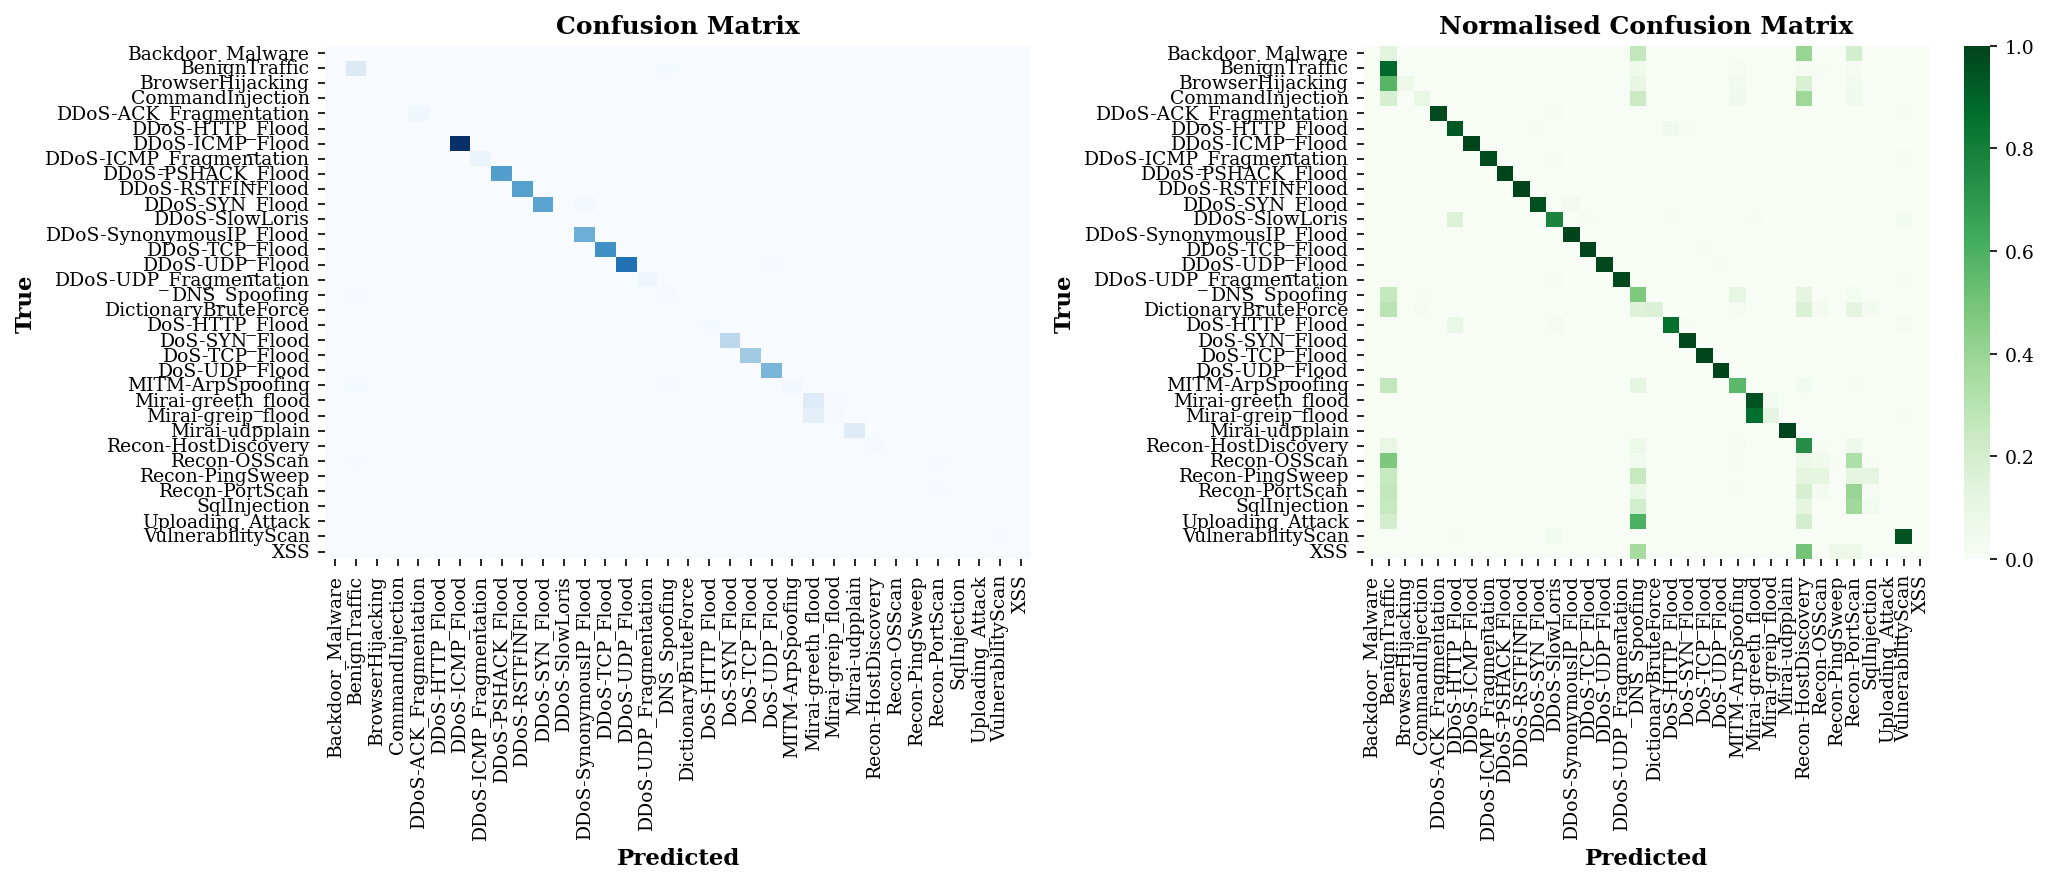

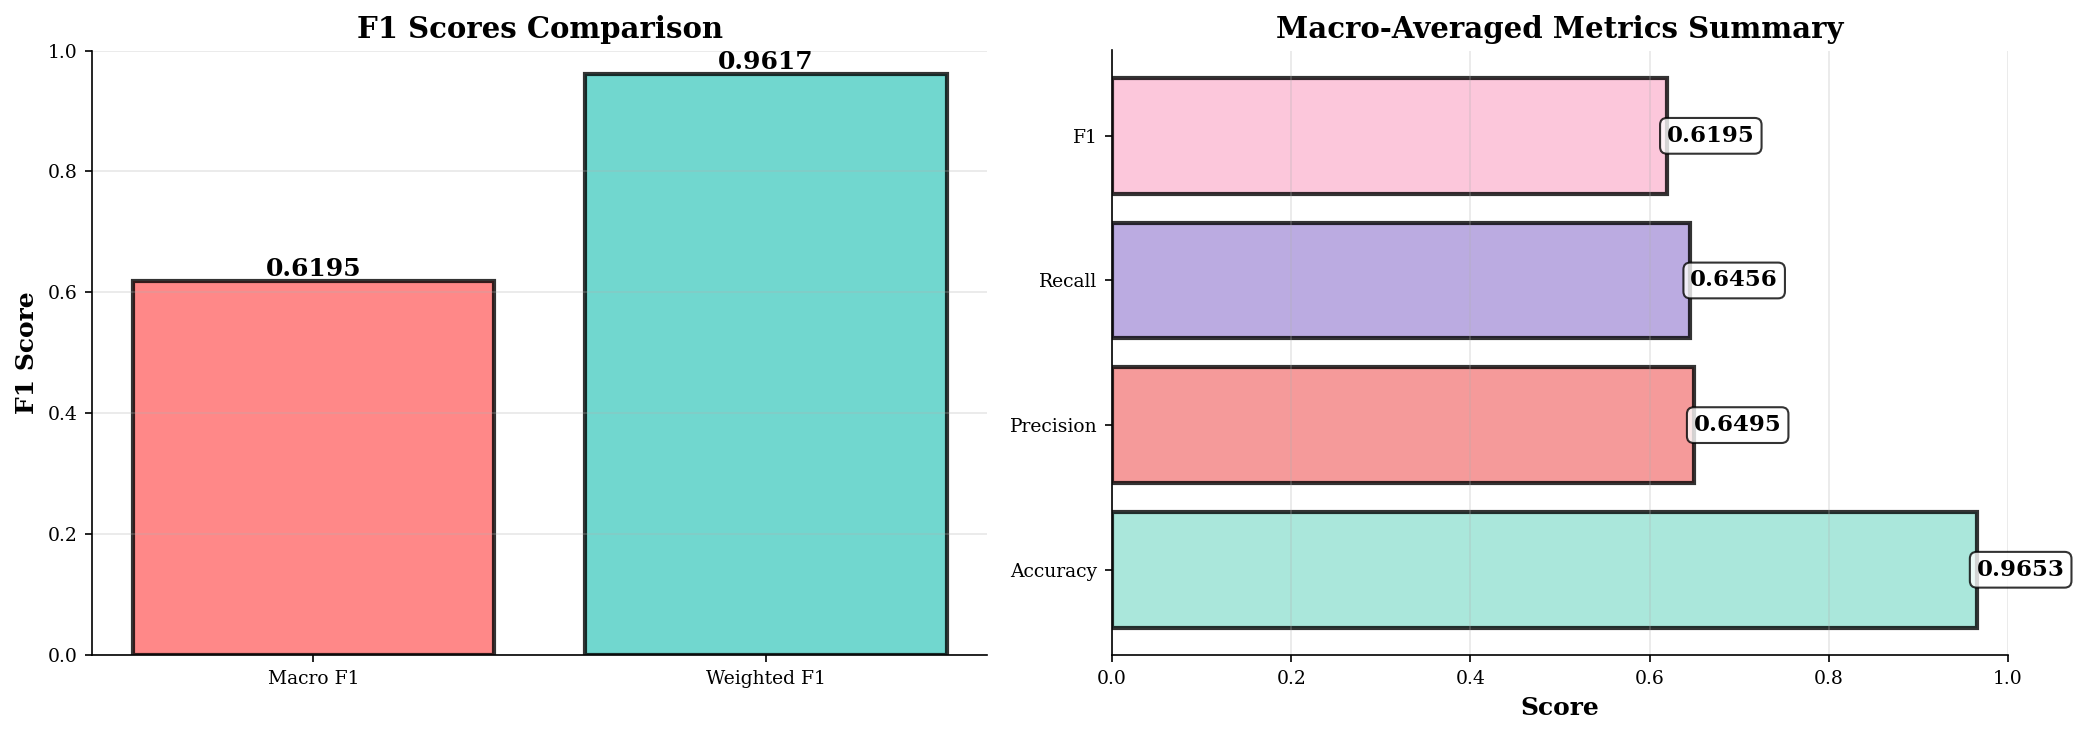

 Metrics summary visualization saved as 'metrics_summary.png'


In [34]:

# Evaluation metrics with attack namess

def evaluate_with_names(all_true, all_preds, all_probs, id_to_attack):
    num_classes = len(id_to_attack)
    class_names = [id_to_attack[i] for i in range(num_classes)]

    print("=" * 80)
    print("MODEL EVALUATION METRICS")
    print("=" * 80)

    print("\nClassification Report:")
    print(classification_report(
        all_true,
        all_preds,
        target_names=class_names,
        zero_division=0
    ))

    macro_f1 = f1_score(all_true, all_preds, average='macro', zero_division=0)
    weighted_f1 = f1_score(all_true, all_preds, average='weighted', zero_division=0)

    print("\nF1 Scores:")
    print(f"  Macro F1 Score:     {macro_f1:.4f}")
    print(f"  Weighted F1 Score:  {weighted_f1:.4f}")

    macro_recall = recall_score(all_true, all_preds, average='macro', zero_division=0)
    weighted_recall = recall_score(all_true, all_preds, average='weighted', zero_division=0)
    per_class_recall = recall_score(all_true, all_preds, average=None, zero_division=0)

    print("\nRecall Scores:")
    print(f"  Macro Recall:     {macro_recall:.4f}")
    print(f"  Weighted Recall:  {weighted_recall:.4f}")
    print("  Per-class Recall:")
    for i, r in enumerate(per_class_recall):
        print(f"    {id_to_attack[i]}: {r:.4f}")

    cm = confusion_matrix(all_true, all_preds)
    accuracy = accuracy_score(all_true, all_preds)

    print(f"\nOverall Accuracy: {accuracy:.4f}")
    print("=" * 80)

    return {
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'macro_recall': macro_recall,
        'weighted_recall': weighted_recall,
        'accuracy': accuracy,
        'confusion_matrix': cm
    }

def evaluation_model_metrics(all_true, all_preds, id_to_attack, normalize=True):
    """
    Plots confusion matrix (raw + normalized) and returns per-class recall.
    """

    class_names = [id_to_attack[i] for i in range(len(id_to_attack))]

    # Confusion matrix
    cm = confusion_matrix(all_true, all_preds)

    # Normalised confusion matrix
    if normalize:
        cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
        cm_norm = np.nan_to_num(cm_norm)
    else:
        cm_norm = None

    # Per-class recall
    per_class_recall = recall_score(
        all_true,
        all_preds,
        average=None,
        zero_division=0
    )

    # ---------- Plot ----------
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Raw CM
    sns.heatmap(
        cm,
        ax=axes[0],
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False
    )
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    # Normalised CM
    sns.heatmap(
        cm_norm,
        ax=axes[1],
        cmap="Greens",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=True,
        vmin=0,
        vmax=1
    )
    axes[1].set_title("Normalised Confusion Matrix")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")

    plt.tight_layout()
    plt.show()

    return {
        "confusion_matrix": cm,
        "confusion_matrix_normalised": cm_norm,
        "per_class_recall": per_class_recall
    }

# ROC-AUC curves and metrics heatmap with attack names

def plot_roc_and_heatmap(all_true, all_probs, id_to_attack,
                          max_classes=5,
                          save_path='roc_and_metrics_heatmap.png'):
    num_classes = len(id_to_attack)
    class_names = [id_to_attack[i] for i in range(num_classes)]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # ROC curves (OvR)
    all_true_bin = label_binarize(all_true, classes=range(num_classes))
    colors = plt.cm.Set3(np.linspace(0, 1, num_classes))

    for i in range(min(num_classes, max_classes)):
        fpr, tpr, _ = roc_curve(all_true_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        axes[0].plot(fpr, tpr, lw=2,
                     label=f'{class_names[i]} (AUC={roc_auc:.3f})')

    axes[0].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curves (One-vs-Rest)')
    axes[0].legend(fontsize=8)
    axes[0].grid(True, alpha=0.3)

    # Metrics heatmap
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_true, np.argmax(all_probs, axis=1), average=None, zero_division=0
    )
    metrics_data = np.vstack([precision, recall, f1]).T

    im = axes[1].imshow(metrics_data[:max_classes], cmap='RdYlGn', vmin=0, vmax=1)
    axes[1].set_xticks([0, 1, 2])
    axes[1].set_xticklabels(['Precision', 'Recall', 'F1'])
    axes[1].set_yticks(range(min(num_classes, max_classes)))
    axes[1].set_yticklabels(class_names[:max_classes])
    axes[1].set_title('Per-Class Metrics Heatmap')

    plt.colorbar(im, ax=axes[1])
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Gathering all predictions and probabilities


metrics = evaluate_with_names(
    all_true,
    all_preds,
    all_probs,
    id_to_attack
)

macro_f1 = metrics["macro_f1"]
weighted_f1 = metrics["weighted_f1"]
macro_recall = metrics["macro_recall"]
accuracy = metrics["accuracy"]



viz_metrics = evaluation_model_metrics(
    all_true,
    all_preds,
    id_to_attack,
    normalize=True
)

cm = viz_metrics["confusion_matrix"]
cm_normalized = viz_metrics["confusion_matrix_normalised"]
per_class_recall = viz_metrics["per_class_recall"]


# Additional metrics visualization

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. F1 Scores Comparison
ax1 = axes[0]
metrics = ['Macro F1', 'Weighted F1']
scores = [macro_f1, weighted_f1]
colors_metrics = ['#FF6B6B', '#4ECDC4']
bars = ax1.bar(metrics, scores, color=colors_metrics, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax1.set_title('F1 Scores Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# 2. Macro Metrics Summary
ax2 = axes[1]
macro_precision = precision_score(all_true, all_preds, average='macro', zero_division=0)
summary_metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
summary_values = [accuracy, macro_precision, macro_recall, macro_f1]
colors_summary = ['#95E1D3', '#F38181', '#AA96DA', '#FCBAD3']

bars = ax2.barh(summary_metrics, summary_values, color=colors_summary, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_xlabel('Score', fontsize=12, fontweight='bold')
ax2.set_title('Macro-Averaged Metrics Summary', fontsize=14, fontweight='bold')
ax2.set_xlim([0, 1]) 
ax2.grid(True, alpha=0.3, axis='x')

for bar, value in zip(bars, summary_values):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2.,
             f'{value:.4f}', ha='left', va='center', fontsize=11, fontweight='bold', 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('metrics_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Metrics summary visualization saved as 'metrics_summary.png'")


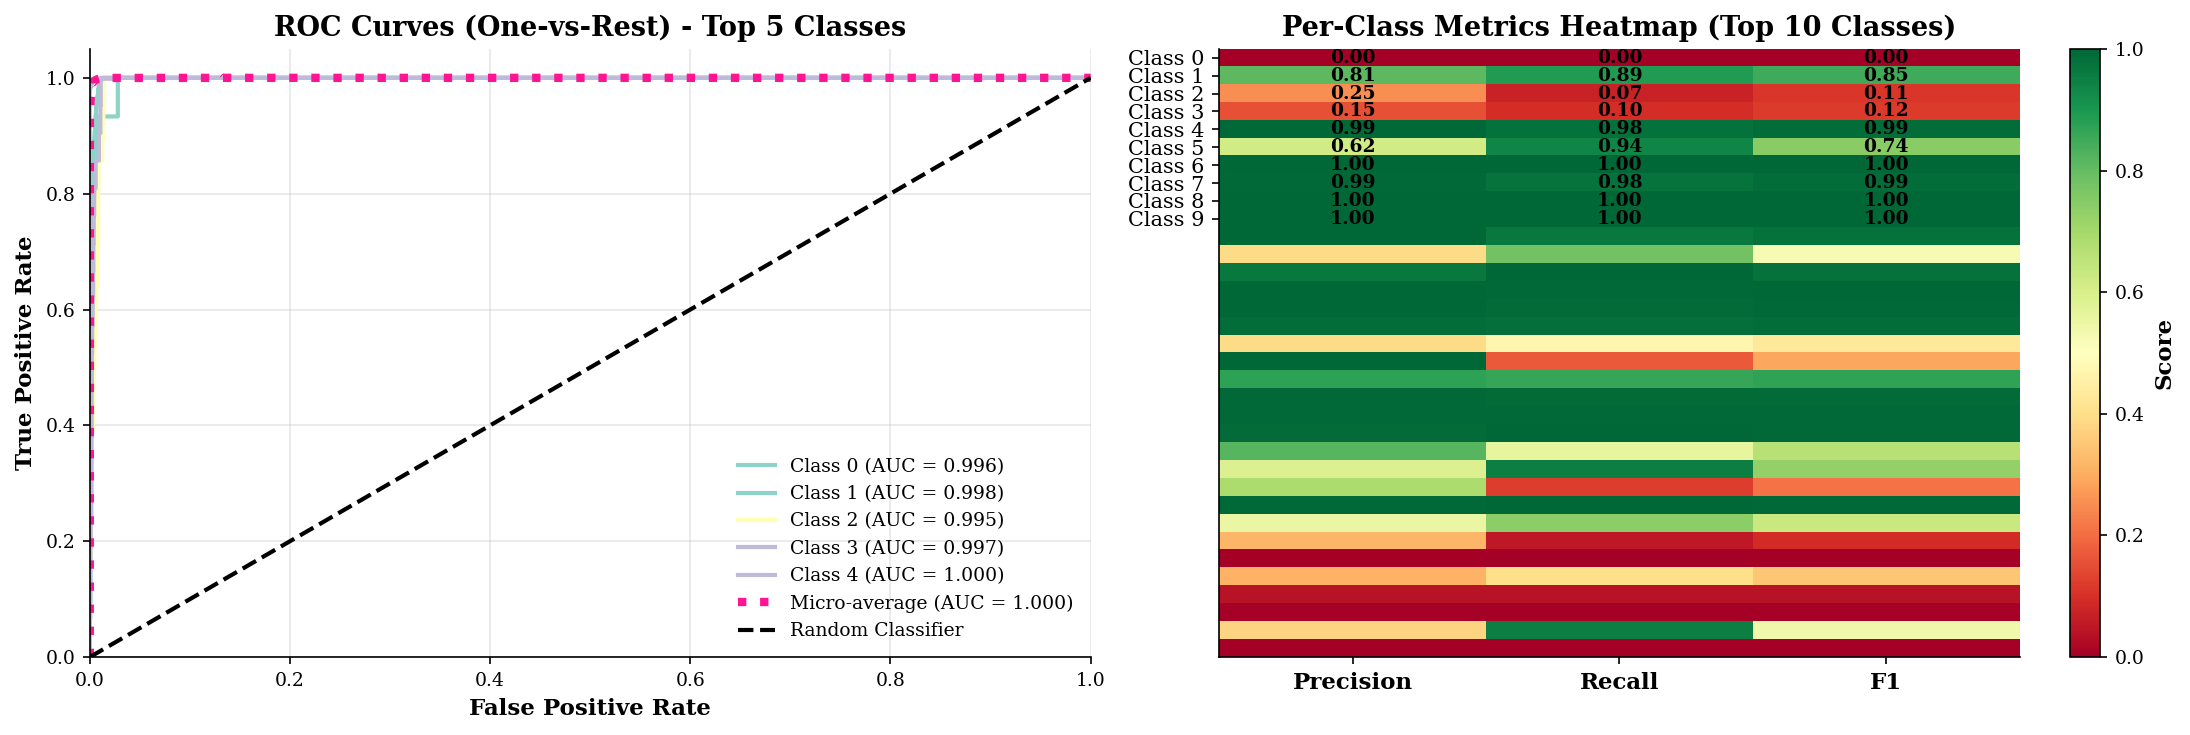

 ROC and metrics heatmap visualization saved as 'roc_and_metrics_heatmap.png'


In [35]:
# ROC-AUC Curves (One-vs-Rest for multi-class)


fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. ROC Curve (One-vs-Rest)
ax1 = axes[0]
if num_classes > 2:
    # Multi-class: use label binarization
    all_true_bin = label_binarize(all_true, classes=range(num_classes))
    
    colors = plt.cm.Set3(np.linspace(0, 2, num_classes))
    auc_scores = []
    
    for i in range(min(num_classes, 5)):  # Limit to 5 classes for clarity
        fpr, tpr, _ = roc_curve(all_true_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        ax1.plot(fpr, tpr, color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc:.3f})')
    
    # Micro-average
    fpr, tpr, _ = roc_curve(all_true_bin.ravel(), all_probs.ravel())
    roc_auc_micro = auc(fpr, tpr)
    ax1.plot(fpr, tpr, color='deeppink', lw=4, linestyle=':', label=f'Micro-average (AUC = {roc_auc_micro:.3f})')
    
    ax1.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax1.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax1.set_title('ROC Curves (One-vs-Rest) - Top 5 Classes', fontsize=13, fontweight='bold')
    ax1.legend(loc="lower right", fontsize=9)
    ax1.grid(True, alpha=0.3)
else:
    # Binary classification
    fpr, tpr, _ = roc_curve(all_true, all_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax1.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax1.set_title('ROC Curve', fontsize=13, fontweight='bold')
    ax1.legend(loc="lower right", fontsize=10)
    ax1.grid(True, alpha=0.3)

# 2. Per-Class Metrics Heatmap
ax2 = axes[1]
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, support = precision_recall_fscore_support(all_true, all_preds, 
                                                                   average=None, zero_division=0)

metrics_data = np.array([precision, recall, f1]).T
im = ax2.imshow(metrics_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

# Set ticks and labels
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['Precision', 'Recall', 'F1'], fontsize=11, fontweight='bold')
ax2.set_yticks(range(min(len(precision), 10)))
ax2.set_yticklabels([f'Class {i}' for i in range(min(len(precision), 10))], fontsize=10)
ax2.set_title('Per-Class Metrics Heatmap (Top 10 Classes)', fontsize=13, fontweight='bold')

# Add text annotations
for i in range(min(len(precision), 10)):
    for j in range(3):
        text = ax2.text(j, i, f'{metrics_data[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=9, fontweight='bold')

cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('Score', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('roc_and_metrics_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(" ROC and metrics heatmap visualization saved as 'roc_and_metrics_heatmap.png'")

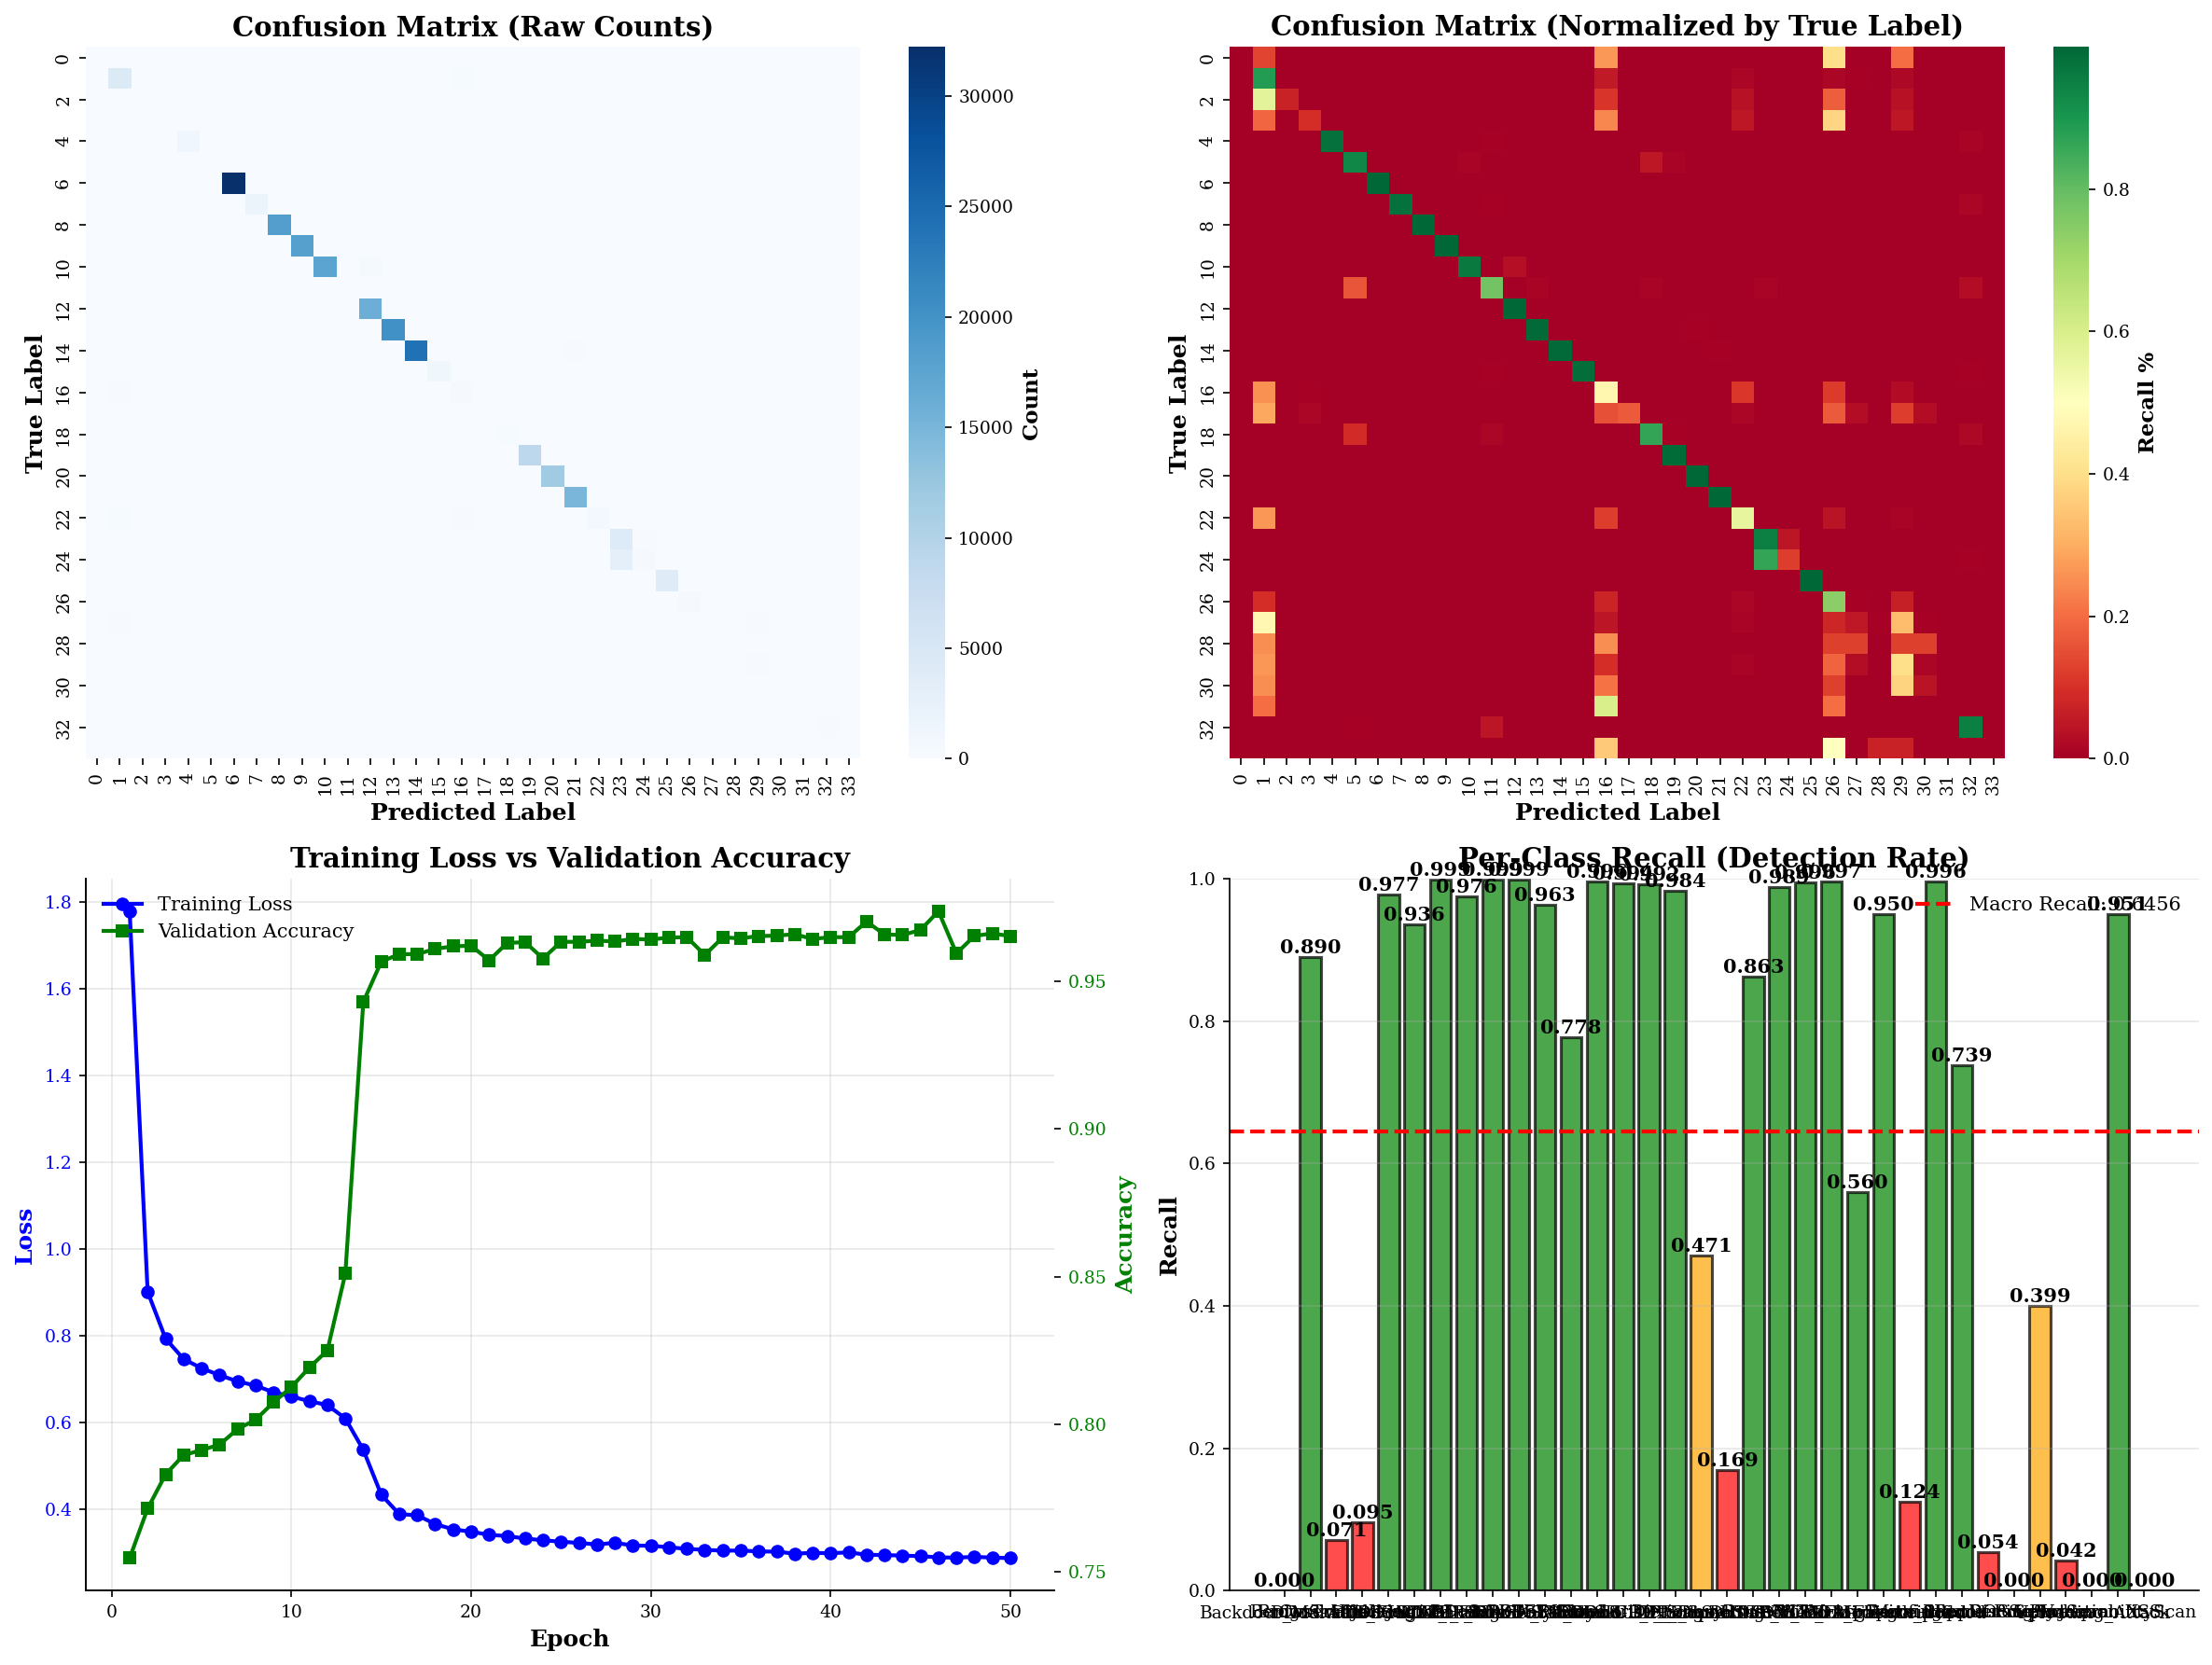


 Visualizations saved as 'model_evaluation_metrics.png'


In [36]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Confusion Matrix Heatmap
ax1 = axes[0, 0]
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_title('Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_xlabel('Predicted Label', fontsize=12)

# 2. Normalized Confusion Matrix
ax2 = axes[0, 1]
sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='RdYlGn', ax=ax2, cbar_kws={'label': 'Recall %'})
ax2.set_title('Confusion Matrix (Normalized by True Label)', fontsize=14, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_xlabel('Predicted Label', fontsize=12)

# 3. Training Loss and Validation Accuracy
ax3 = axes[1, 0]
epochs_range = range(1, len(loss_across_epochs) + 1)
ax3_twin = ax3.twinx()
line1 = ax3.plot(epochs_range, loss_across_epochs, 'b-o', label='Training Loss', linewidth=2, markersize=6)
line2 = ax3_twin.plot(epochs_range, val_accuracy_across_epochs, 'g-s', label='Validation Accuracy', linewidth=2, markersize=6)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Loss', fontsize=12, color='b')
ax3_twin.set_ylabel('Accuracy', fontsize=12, color='g')
ax3.tick_params(axis='y', labelcolor='b')
ax3_twin.tick_params(axis='y', labelcolor='g')
ax3.grid(True, alpha=0.3)
ax3.set_title('Training Loss vs Validation Accuracy', fontsize=14, fontweight='bold')

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax3.legend(lines, labels, loc='upper left', fontsize=10)

# 4. Per-Class Recall Bar Chart
ax4 = axes[1, 1]
class_names = [id_to_attack[i] for i in range(len(per_class_recall))]

colors = ['green' if r > 0.5 else 'orange' if r > 0.3 else 'red' for r in per_class_recall]
bars = ax4.bar(class_names, per_class_recall, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.axhline(y=macro_recall, color='r', linestyle='--', linewidth=2, label=f'Macro Recall: {macro_recall:.4f}')
ax4.set_ylabel('Recall', fontsize=12)
ax4.set_title('Per-Class Recall (Detection Rate)', fontsize=14, fontweight='bold')
ax4.set_ylim([0, 1])
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, recall in zip(bars, per_class_recall):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{recall:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('model_evaluation_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Visualizations saved as 'model_evaluation_metrics.png'")
